In [70]:
!pip install lifetimes

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
data=pd.read_csv('/content/drive/MyDrive/Online Retail.csv')

In [73]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [74]:
data.shape

(541909, 8)

In [75]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [76]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [77]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'],format='%m/%d/%y %H:%M').dt.date

In [78]:
data=data[pd.notnull(data['CustomerID'])]

In [79]:
data=data[data['Quantity']>0]

In [80]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France


In [81]:
data['Total']=data['Quantity']*data['UnitPrice']

In [82]:
cols=['CustomerID','InvoiceDate','Total']

In [83]:
data=data[cols]

In [84]:
data.head()

,CustomerID,InvoiceDate,Total
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [85]:
data['CustomerID'].nunique()

4339

In [86]:
last_order_date=data['InvoiceDate'].max()

In [87]:
last_order_date

datetime.date(2011, 12, 9)

In [88]:
from lifetimes.utils import summary_data_from_transaction_data

In [89]:
df=summary_data_from_transaction_data(data,'CustomerID','InvoiceDate',monetary_value_col='Total',observation_period_end=last_order_date)

In [90]:
df.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


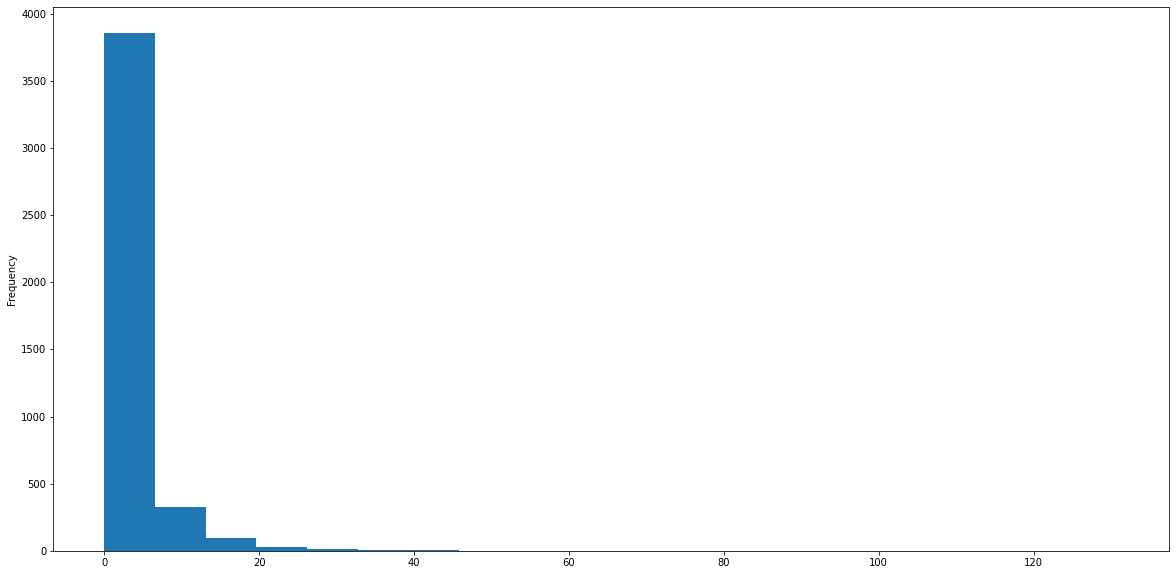

In [91]:
fig=plt.figure(figsize=(20,10))
df['frequency'].plot(kind='hist',bins=20)

In [92]:
df['frequency'].describe()


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64

In [93]:
one_time=round(sum(df['frequency']==0)/float(len(df))*100,2)

In [94]:
print("Percentage of one time customers is",one_time,"%")

Percentage of one time customers is 35.7 %


**Frequency and Recency Analysis | BG/NBD Model**

In [95]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(df['frequency'], df['recency'], df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [96]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


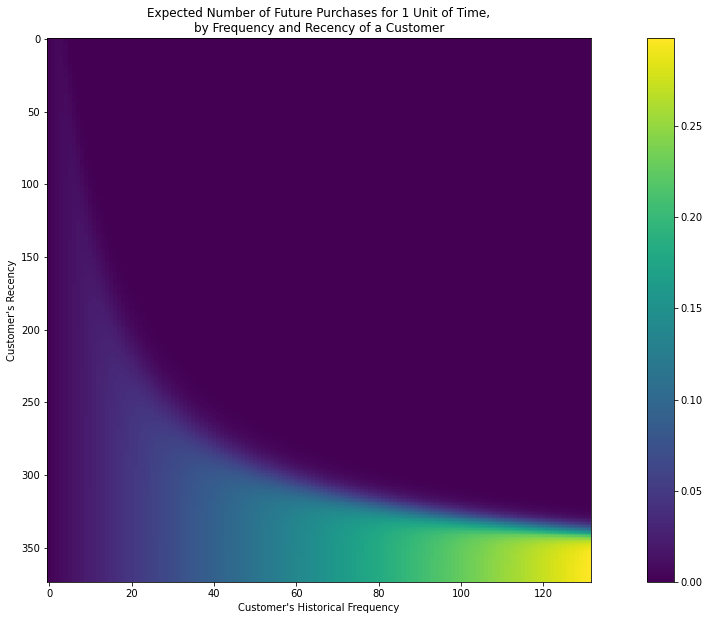

In [97]:

from lifetimes.plotting import plot_frequency_recency_matrix
fig=plt.figure(figsize=(20,10))
plot_frequency_recency_matrix(bgf)

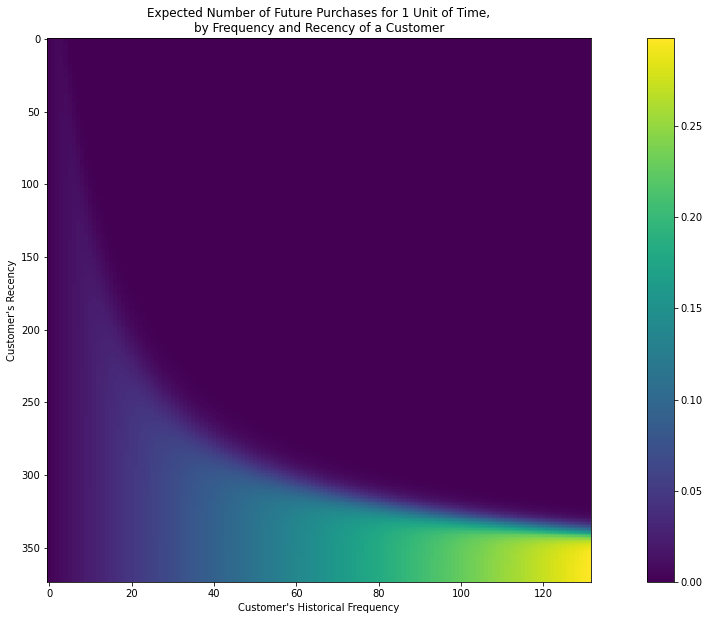

In [98]:
#Prediction for Active Customers
from lifetimes.plotting import plot_probability_alive_matrix
fig=plt.figure(figsize=(20,10))
plot_frequency_recency_matrix(bgf)

In [99]:
t=20
df['transaction']=round(bgf.conditional_expected_number_of_purchases_up_to_time(t,df['frequency'],df['recency'],df['T']),2)
df.sort_values('transaction',ascending=False).head(20).reset_index()

,CustomerID,frequency,recency,T,monetary_value,transaction
0,14911.0,131.0,372.0,373.0,1093.661679,5.97
1,12748.0,113.0,373.0,373.0,298.360885,5.15
2,17841.0,111.0,372.0,373.0,364.452162,5.06
3,15311.0,89.0,373.0,373.0,677.729438,4.07
4,14606.0,88.0,372.0,373.0,135.890114,4.02
5,12971.0,70.0,369.0,372.0,159.211286,3.21
6,13089.0,65.0,367.0,369.0,893.714308,3.01
7,14527.0,53.0,367.0,369.0,155.016415,2.46
8,13798.0,52.0,371.0,372.0,706.650962,2.40
9,16422.0,47.0,352.0,369.0,702.472340,2.18


In [100]:
from lifetimes.plotting import plot_period_transactions

<Figure size 1440x720 with 0 Axes>

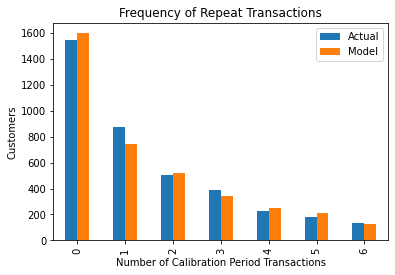

In [102]:
plot_period_transactions(bgf)

In [107]:
#Individual customer Future Prediction for next 20 days
t=20
Individual=df.iloc[1510]
bgf.predict(t,Individual['frequency'],Individual['recency'],Individual['T'])

0.22075183728884037

In [109]:
df[['monetary_value','frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


In [111]:
import seaborn as sns

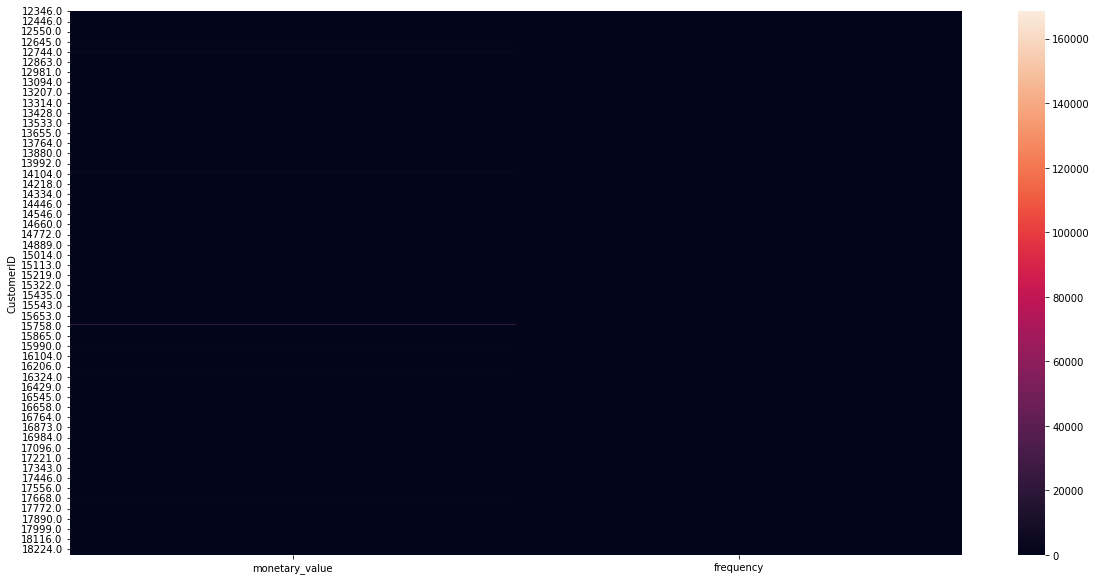

In [113]:
fig=plt.figure(figsize=(20,10))
sns.heatmap(df[['monetary_value','frequency']])

In [114]:
# Customers with atleast one repeat purchase
shortlisted=df[df['frequency']>0]

len(shortlisted)

2790

In [115]:
shortlisted.head().reset_index()

,CustomerID,frequency,recency,T,monetary_value,transaction
0,12347.0,6.0,365.0,367.0,599.701667,0.31
1,12348.0,3.0,283.0,358.0,301.480000,0.18
2,12352.0,6.0,260.0,296.0,368.256667,0.37
3,12356.0,2.0,303.0,325.0,269.905000,0.14
4,12358.0,1.0,149.0,150.0,683.200000,0.17


**GAMMA-GAMMA Model**

In [116]:
from lifetimes import GammaGammaFitter
ggf=GammaGammaFitter(penalizer_coef=0)
ggf.fit(shortlisted['frequency'],shortlisted['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [117]:
ggf

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [118]:
ggf.conditional_expected_average_profit(df['frequency'],df['monetary_value']).head()

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
dtype: float64

In [119]:
df['transaction_value']=round(ggf.conditional_expected_average_profit(df['frequency'],df['monetary_value']),2)
df.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,transaction,transaction_value
0,12346.0,0.0,0.0,325.0,0.000000,0.04,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.31,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.18,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.19,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.04,416.92


In [120]:
df['CLV']=round(ggf.customer_lifetime_value(bgf,df['frequency'],df['recency'],df['T'],df['monetary_value'],time=12,discount_rate=0.01),2)

In [121]:
df.sort_values(by='CLV',ascending=False).reset_index()

,CustomerID,frequency,recency,T,monetary_value,transaction,transaction_value,CLV
0,14646.0,44.0,353.0,354.0,6366.705909,2.12,6213.28,222128.93
1,18102.0,25.0,367.0,367.0,9349.477200,1.18,8951.86,178895.33
2,16446.0,1.0,205.0,205.0,168469.600000,0.13,78051.29,175531.47
3,17450.0,26.0,359.0,367.0,7404.690385,1.23,7105.09,147476.62
4,14096.0,16.0,97.0,101.0,4071.434375,1.98,3823.47,127589.20
...,...,...,...,...,...,...,...,...
4334,17643.0,0.0,0.0,373.0,0.000000,0.04,416.92,263.19
4335,17908.0,0.0,0.0,373.0,0.000000,0.04,416.92,263.19
4336,17968.0,0.0,0.0,373.0,0.000000,0.04,416.92,263.19
4337,18011.0,0.0,0.0,373.0,0.000000,0.04,416.92,263.19
